# Objetivo
En base al conjunto de dataset que disponemos, aprender a analizar la correlacion existente entre los diferentes atributos,para ser capaces de entrenar modelos y realizar predicciones de un atributo en concreto.

# Librerias Usadas


In [911]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import scipy.stats
import seaborn as sns

# Apartado C

## Cargamos la base de datos

In [912]:
#Obligamos que meutre todas las columnas
pd.set_option('display.max_columns', None)

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('db\\Data_train_reduced.csv')
dataset_copy = load_dataset('db\\Data_train_reduced.csv')
dataset_test = load_dataset('db\\test_data.csv')
data = dataset.values

x = data[:, :2]
y = data[:, 2]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (2500, 64)
Dimensionalitat de les entrades X (2500, 2)
Dimensionalitat de l'atribut Y (2500,)


# Entendemos nuestros datos
## Tipo de datos

In [913]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 64 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Respondent.ID                                            2500 non-null   int64  
 1   Product.ID                                               2500 non-null   int64  
 2   Product                                                  2500 non-null   object 
 3   Instant.Liking                                           2500 non-null   int64  
 4   q1_1.personal.opinion.of.this.Deodorant                  2500 non-null   int64  
 5   q2_all.words                                             2500 non-null   int64  
 6   q3_1.strength.of.the.Deodorant                           2500 non-null   int64  
 7   q4_1.artificial.chemical                                 2500 non-null   int64  
 8   q4_2.attractive             

## Buscamos si tenemos datos nulos
Como podemos observar no tenemos ninguna perdida de datos

In [914]:
dataset.isnull().sum()

Respondent.ID                                     0
Product.ID                                        0
Product                                           0
Instant.Liking                                    0
q1_1.personal.opinion.of.this.Deodorant           0
                                                 ..
s11.marital.status                                0
s12.working.status                                0
s13.2                                             0
s13a.b.most.often                                 0
s13b.bottles.of.Deodorant.do.you.currently.own    0
Length: 64, dtype: int64

Para tener un mejor punto de vista de los valores nulos, crearemos una grafica donde nos lo indique visualmente

<AxesSubplot:>

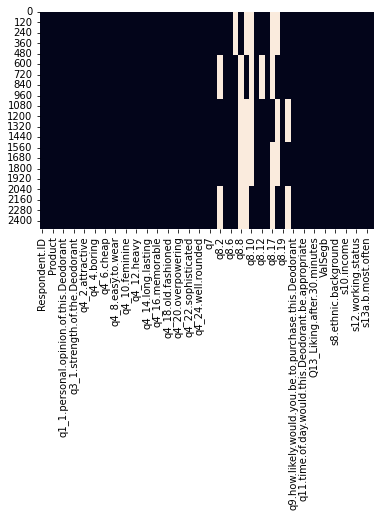

In [915]:
sns.heatmap(dataset.isnull(), cbar=False)

Eliminamos los valores nulos

Columns containing nan values:Index(['q8.2', 'q8.7', 'q8.8', 'q8.9', 'q8.10', 'q8.12', 'q8.17', 'q8.18',
       'q8.20'],
      dtype='object')
Columns containing nan values:Index([], dtype='object')


<AxesSubplot:>

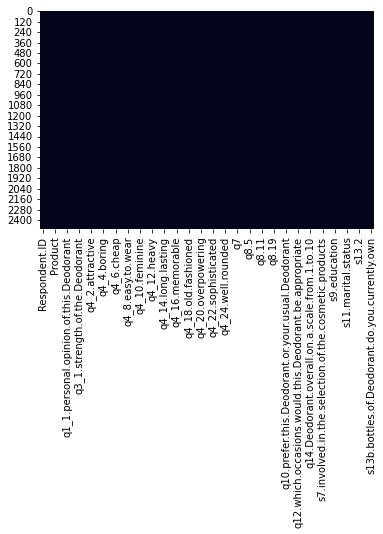

In [916]:
def columns_with_na(dframe):
    temp = dframe.isna().sum()
    temp = temp[temp >0]
    print(f"Columns containing nan values:{temp.index}")
    return temp.index

columns_to_drop = list(columns_with_na(dataset))
columns_to_drop_test = list(columns_with_na(dataset_test))

dataset.drop(columns_to_drop, axis=1, inplace = True)
dataset_test.drop(columns_to_drop_test, axis=1, inplace = True)
dataset_copy.drop(columns_to_drop, axis=1 ,inplace = True)

sns.heatmap(dataset.isnull(), cbar=False)

## Estadisticas de los datos

In [917]:
dataset.describe()

,Respondent.ID,Product.ID,Instant.Liking,q1_1.personal.opinion.of.this.Deodorant,q2_all.words,q3_1.strength.of.the.Deodorant,q4_1.artificial.chemical,q4_2.attractive,q4_3.bold,q4_4.boring,q4_5.casual,q4_6.cheap,q4_7.clean,q4_8.easy.to.wear,q4_9.elegant,q4_10.feminine,q4_11.for.someone.like.me,q4_12.heavy,q4_13.high.quality,q4_14.long.lasting,q4_15.masculine,q4_16.memorable,q4_17.natural,q4_18.old.fashioned,q4_19.ordinary,q4_20.overpowering,q4_21.sharp,q4_22.sophisticated,q4_23.upscale,q4_24.well.rounded,q5_1.Deodorant.is.addictive,q7,q8.1,q8.5,q8.6,q8.11,q8.13,q8.19,q9.how.likely.would.you.be.to.purchase.this.Deodorant,q10.prefer.this.Deodorant.or.your.usual.Deodorant,q11.time.of.day.would.this.Deodorant.be.appropriate,q12.which.occasions.would.this.Deodorant.be.appropriate,Q13_Liking.after.30.minutes,q14.Deodorant.overall.on.a.scale.from.1.to.10,ValSegb,s7.involved.in.the.selection.of.the.cosmetic.products,s8.ethnic.background,s9.education,s10.income,s11.marital.status,s12.working.status,s13.2,s13a.b.most.often,s13b.bottles.of.Deodorant.do.you.currently.own
count,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000,2500.000
mean,8249.500,460.400,0.247,5.130,1.121,3.344,2.500,3.717,3.546,2.242,3.487,2.348,3.789,3.751,3.628,4.016,3.558,2.809,3.683,4.003,2.078,3.826,3.467,2.629,2.860,2.979,3.332,3.635,3.528,3.648,3.336,1.400,0.047,0.053,0.049,0.021,0.038,0.005,3.590,2.826,2.318,2.195,4.960,6.747,3.522,4.000,1.665,3.199,4.996,1.742,1.898,0.025,0.038,3.072
std,3433.009,308.413,0.431,1.482,0.934,0.743,1.385,1.275,1.262,1.243,1.277,1.312,1.209,1.306,1.260,1.200,1.368,1.474,1.220,1.102,1.272,1.164,1.278,1.409,1.301,1.426,1.307,1.271,1.281,1.197,1.319,1.265,0.212,0.224,0.215,0.143,0.192,0.072,1.397,1.398,0.805,0.849,1.769,2.505,1.964,0.000,1.037,0.970,2.371,0.727,1.440,0.105,0.192,1.620
min,3800.000,121.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-4.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,4.000,1.000,2.000,2.000,1.000,1.000,0.000,0.000,1.000
25%,5324.750,230.000,0.000,5.000,0.000,3.000,1.000,3.000,3.000,1.000,3.000,1.000,3.000,3.000,3.000,4.000,3.000,1.000,3.000,3.000,1.000,3.000,3.000,1.000,2.000,2.000,2.000,3.000,3.000,3.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,2.000,2.000,1.000,4.000,5.000,2.000,4.000,1.000,2.000,3.000,1.000,1.000,0.000,0.000,2.000
50%,8249.500,344.000,0.000,5.000,1.000,3.000,2.000,4.000,4.000,2.000,4.000,2.000,4.000,4.000,4.000,4.000,4.000,3.000,4.000,4.000,2.000,4.000,4.000,2.000,3.000,3.000,4.000,4.000,4.000,4.000,4.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,3.000,3.000,2.000,5.000,7.000,3.000,4.000,1.000,3.000,4.000,2.000,1.000,0.000,0.000,3.000
75%,9774.250,633.000,0.000,6.000,2.000,4.000,4.000,5.000,5.000,3.000,5.000,3.000,5.000,5.000,5.000,5.000,5.000,4.000,5.000,5.000,3.000,5.000,5.000,4.000,4.000,4.000,4.000,5.000,5.000,5.000,4.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,4.000,3.000,3.000,6.000,9.000,5.000,4.000,2.000,4.000,7.000,2.000,2.000,0.000,0.000,4.000
max,14099.000,974.000,1.000,7.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,7.000,1.000,1.000,1.000,1.000,1.000,1.000,5.000,5.000,3.000,3.000,7.000,10.000,7.000,4.000,5.000,7.000,10.000,5.000,7.000,1.000,1.000,6.000


## Los atributos

In [918]:
dataset.keys()

Index(['Respondent.ID', 'Product.ID', 'Product', 'Instant.Liking',
       'q1_1.personal.opinion.of.this.Deodorant', 'q2_all.words',
       'q3_1.strength.of.the.Deodorant', 'q4_1.artificial.chemical',
       'q4_2.attractive', 'q4_3.bold', 'q4_4.boring', 'q4_5.casual',
       'q4_6.cheap', 'q4_7.clean', 'q4_8.easy.to.wear', 'q4_9.elegant',
       'q4_10.feminine', 'q4_11.for.someone.like.me', 'q4_12.heavy',
       'q4_13.high.quality', 'q4_14.long.lasting', 'q4_15.masculine',
       'q4_16.memorable', 'q4_17.natural', 'q4_18.old.fashioned',
       'q4_19.ordinary', 'q4_20.overpowering', 'q4_21.sharp',
       'q4_22.sophisticated', 'q4_23.upscale', 'q4_24.well.rounded',
       'q5_1.Deodorant.is.addictive', 'q7', 'q8.1', 'q8.5', 'q8.6', 'q8.11',
       'q8.13', 'q8.19',
       'q9.how.likely.would.you.be.to.purchase.this.Deodorant',
       'q10.prefer.this.Deodorant.or.your.usual.Deodorant',
       'q11.time.of.day.would.this.Deodorant.be.appropriate',
       'q12.which.occasions.would

## Mostramos los 5 priemros datos

In [919]:
dataset.head()

,Respondent.ID,Product.ID,Product,Instant.Liking,q1_1.personal.opinion.of.this.Deodorant,q2_all.words,q3_1.strength.of.the.Deodorant,q4_1.artificial.chemical,q4_2.attractive,q4_3.bold,q4_4.boring,q4_5.casual,q4_6.cheap,q4_7.clean,q4_8.easy.to.wear,q4_9.elegant,q4_10.feminine,q4_11.for.someone.like.me,q4_12.heavy,q4_13.high.quality,q4_14.long.lasting,q4_15.masculine,q4_16.memorable,q4_17.natural,q4_18.old.fashioned,q4_19.ordinary,q4_20.overpowering,q4_21.sharp,q4_22.sophisticated,q4_23.upscale,q4_24.well.rounded,q5_1.Deodorant.is.addictive,q7,q8.1,q8.5,q8.6,q8.11,q8.13,q8.19,q9.how.likely.would.you.be.to.purchase.this.Deodorant,q10.prefer.this.Deodorant.or.your.usual.Deodorant,q11.time.of.day.would.this.Deodorant.be.appropriate,q12.which.occasions.would.this.Deodorant.be.appropriate,Q13_Liking.after.30.minutes,q14.Deodorant.overall.on.a.scale.from.1.to.10,ValSegb,s7.involved.in.the.selection.of.the.cosmetic.products,s8.ethnic.background,s9.education,s10.income,s11.marital.status,s12.working.status,s13.2,s13a.b.most.often,s13b.bottles.of.Deodorant.do.you.currently.own
0,3800,121,Deodorant B,1,4,1,4,2,5,4,2,3,5,5,5,4,5,3,1,5,1,2,4,5,4,5,1,1,4,1,4,1,1,0,0,0,0,0,0,2,1,1,2,1,7,7,4,1,4,3,1,1,0.000,0,3
1,3801,121,Deodorant B,0,5,1,4,4,2,2,1,3,2,4,4,4,3,1,1,3,4,4,5,3,3,4,2,2,5,4,4,4,4,0,0,1,0,0,0,3,5,3,3,3,8,6,4,1,4,3,1,1,0.000,0,4
2,3802,121,Deodorant B,0,6,1,3,2,5,2,4,2,4,3,5,4,4,4,3,1,2,1,4,2,4,3,2,5,4,4,3,4,3,0,0,0,0,0,0,5,1,3,3,2,5,7,4,1,3,5,1,1,0.000,0,2
3,3803,121,Deodorant B,1,4,0,4,5,5,4,3,5,2,5,3,5,5,5,1,4,3,3,5,5,4,2,5,3,3,5,4,4,3,0,0,0,0,0,0,5,4,1,3,6,8,1,4,1,4,9,1,3,0.000,0,3
4,3804,121,Deodorant B,1,4,1,2,1,3,1,1,3,3,5,3,5,5,5,1,4,4,2,3,5,1,2,4,2,3,1,5,3,2,0,0,0,0,0,0,5,3,3,2,5,4,4,4,1,3,5,1,2,0.000,0,3


Entendemos que tipo de producto tenemos

In [920]:
print(dataset['Product'].value_counts())
print("Total = ", len(dataset))

Deodorant B    500
Deodorant F    500
Deodorant G    500
Deodorant H    500
Deodorant J    500
Name: Product, dtype: int64
Total =  2500


## Mostrar datos

Mostramos la media de valoracion que tiene cada producto (no tiene porque ser mejor el mayor, ya que hay preguntas negativas)

C:\Users\LUISFE~1\AppData\Local\Temp/ipykernel_18048/2622846732.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset['mean']=(dataset.mean(axis=1)/(dataset.shape[1]-3))


<BarContainer object of 2500 artists>

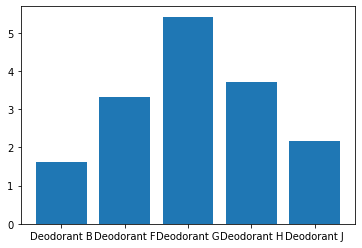

In [921]:
dataset['mean']=(dataset.mean(axis=1)/(dataset.shape[1]-3))
plt.bar(dataset['Product'],dataset['mean'])

Miramos si existe alguna correlación entre los atributos, nuestra lógica dice que entre los atributos instan_liking y personal_opinion debe de haber alguna relación

<AxesSubplot:>

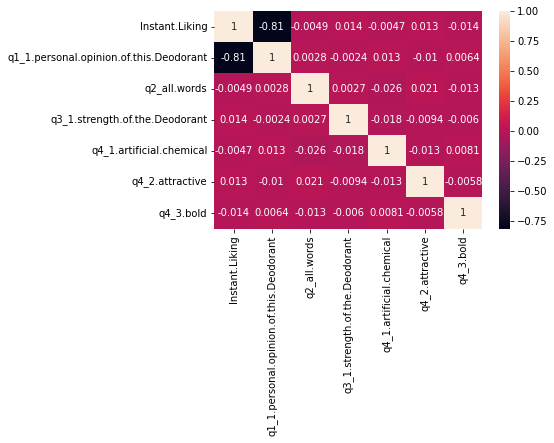

In [922]:
correlacio = dataset.iloc[:,3:10].corr()

fig , ax = plt.subplots()
sns.heatmap(correlacio,annot=True)

Creamos graficas de todos los atributos

array([[<AxesSubplot:title={'center':'Respondent.ID'}>,
        <AxesSubplot:title={'center':'Product.ID'}>,
        <AxesSubplot:title={'center':'Instant.Liking'}>,
        <AxesSubplot:title={'center':'q1_1.personal.opinion.of.this.Deodorant'}>,
        <AxesSubplot:title={'center':'q2_all.words'}>,
        <AxesSubplot:title={'center':'q3_1.strength.of.the.Deodorant'}>,
        <AxesSubplot:title={'center':'q4_1.artificial.chemical'}>],
       [<AxesSubplot:title={'center':'q4_2.attractive'}>,
        <AxesSubplot:title={'center':'q4_3.bold'}>,
        <AxesSubplot:title={'center':'q4_4.boring'}>,
        <AxesSubplot:title={'center':'q4_5.casual'}>,
        <AxesSubplot:title={'center':'q4_6.cheap'}>,
        <AxesSubplot:title={'center':'q4_7.clean'}>,
        <AxesSubplot:title={'center':'q4_8.easy.to.wear'}>],
       [<AxesSubplot:title={'center':'q4_9.elegant'}>,
        <AxesSubplot:title={'center':'q4_10.feminine'}>,
        <AxesSubplot:title={'center':'q4_11.for.someone.lik

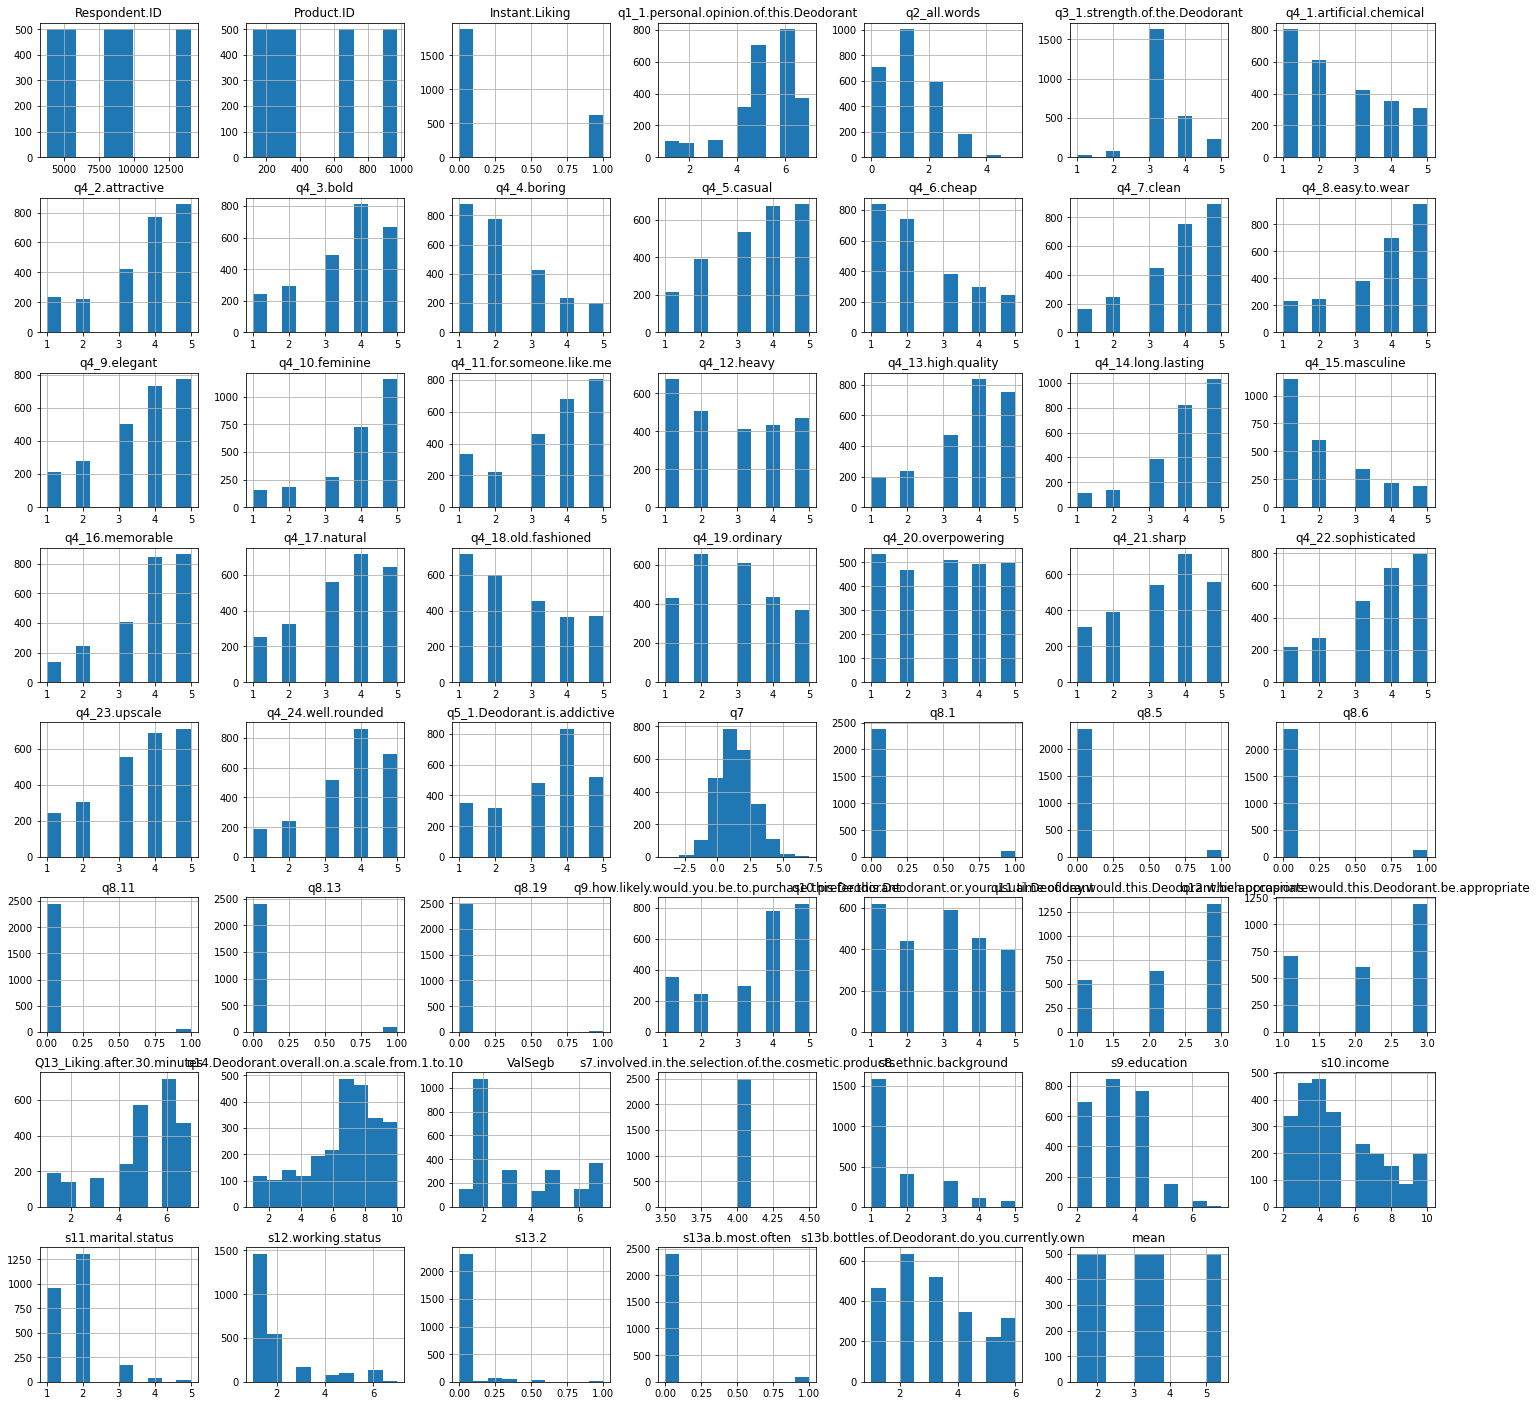

In [923]:
dataset.hist(figsize=(25,25))

## Preguntas
### ¿Cuál es el tipo de cada atributo?

Para determinar el tipo de atributo, podemos hacer uso de la funcion dataset.info() que nos muestra el tipo de valor de cada uno de los elementos de los que esta compuesto nuestro dataset.
Por ejemplo en nuestro caso, al ejecutar dicho comando nos devuelve una lista de cada una de las columnas, y al final del todo nos proporciona la siguiente informacion:
dtypes: float64(10), int64(53), object(1)

### ¿Qué atributos tienen una distribución Guassiana?
En nuestro caso para poder determinar que atributo tenia dicha distribucion, hemos hecho uso de la comanda dataset.hist(figsize=(20,20)), esto nos devuelve un histograma para cada uno de los atributos del dataset, y hemos identificado que el atributo q7 y la media tienen una distribucion Guassiana.

### ¿Cuál es el atributo objetivo? ¿Por qué?
Despues del analisis de los datos que disponemos, llegamos a la conclusion que lo ideal seria predecir el tipo de producto en base al conjunto de 'Xs' de entrada, ya que en este caso disponemos de un sin numero de entradas con valores calificativos de diferentes caracteristicas del producto.

# Apartado B

Tras haber hecho un analisis de los datos podemos determinar la relacion que tenemos entre q1_1.personal.opinion.of.this.Deodorant y Instant.Liking

In [924]:
#seleccionamos solo la comlumna 8 del dataset (desodorantes atractivos)
data = dataset.values

X_train=data[:,np.newaxis,3]
X_pca=data[:,np.newaxis,3]

#Defino los datos correspondientes a las opinion de desodorante
y_train=dataset['q1_1.personal.opinion.of.this.Deodorant']
y_validation=dataset_test['q1_1.personal.opinion.of.this.Deodorant']

## Implementacion de la Regresion lineal

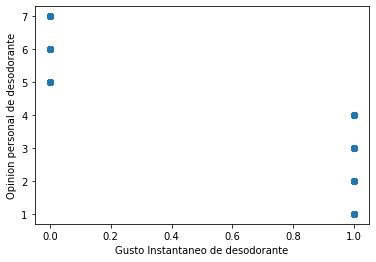

In [925]:
#Determinar la relacion entre q1_1.personal.opinion.of.this.Deodorant y Instant.Liking
plt.scatter(X_train,y_train)
plt.xlabel('Gusto Instantaneo de desodorante')
plt.ylabel('Opinion personal de desodorante')
plt.show()

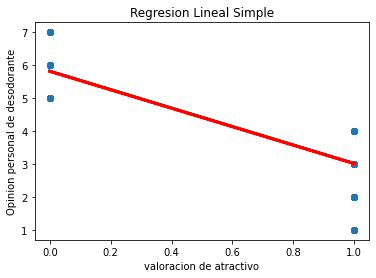

In [926]:
#Separamos los datos de "train" en entrenamiento y prueba
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=15)

#definimos el algoritmo a utilizar
lr = linear_model.LinearRegression()

#Entreno de modelo
lr.fit(X_train, y_train)

#Realizar una prediccion
Y_pred = lr.predict(X_test)

#Graficamos los datos junto con el modelo
plt.scatter(X_test,y_test)
plt.plot(X_test,Y_pred,color='red',linewidth=3)
plt.title('Regresion Lineal Simple')
plt.xlabel('valoracion de atractivo')
plt.ylabel('Opinion personal de desodorante')
plt.show()

Determinamos el error cuadratico (MBR) y la precision del modelo (R2 Score)

In [927]:
print("Mean squeared error: ", mean_squared_error(X_train, y_train))
print("R2 Score: ", lr.score(X_train, y_train))

Mean squeared error:  27.188
R2 Score:  0.6636267790895974


## Segundo ejemplo de regresion  Lineal 

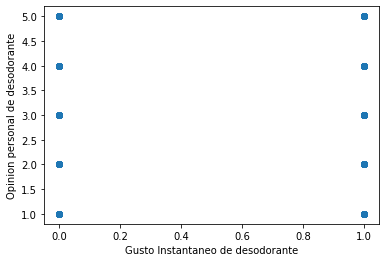

In [928]:
#Determinar la relacion entre q1_1.personal.opinion.of.this.Deodorant y q9.how.likely.would.you.be.to.purchase.this.Deodorant
X=data[:,np.newaxis,3]
y=dataset['q9.how.likely.would.you.be.to.purchase.this.Deodorant']
#Graficamos los datos corrrespondientes
plt.scatter(X,y)
plt.xlabel('Gusto Instantaneo de desodorante')
plt.ylabel('Opinion personal de desodorante')
plt.show()

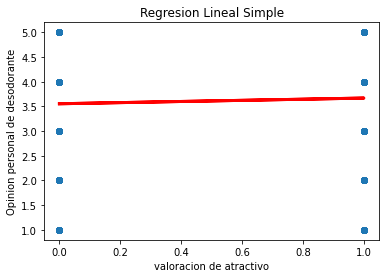

In [929]:
#Separamos los datos de "train" en entrenamiento y prueba
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=15)

#definimos el algoritmo a utilizar
lr = linear_model.LinearRegression()

#Entreno de modelo
lr.fit(X_train, y_train)

#Realizar una prediccion
Y_pred = lr.predict(X_test)

#Graficamos los datos junto con el modelo
plt.scatter(X_test,y_test)
plt.plot(X_test,Y_pred,color='red',linewidth=3)
plt.title('Regresion Lineal Simple')
plt.xlabel('valoracion de atractivo')
plt.ylabel('Opinion personal de desodorante')
plt.show()

In [930]:
print("Mean squeared error: ", mean_squared_error(X_train, y_train))
print("R2 Score: ", lr.score(X_train, y_train))

Mean squeared error:  13.199
R2 Score:  0.0012714162780590454


In [931]:
#NORMALIZANDO
to_drop=['Respondent.ID','Product.ID','Product']
dataset_copy.drop(to_drop, axis=1, inplace = True)
dataset_copy=dataset_copy.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
dataset_norm=(dataset_copy - dataset_copy.min()) / ( dataset_copy.max() - dataset_copy.min())
dataset_norm

,Instant.Liking,q1_1.personal.opinion.of.this.Deodorant,q2_all.words,q3_1.strength.of.the.Deodorant,q4_1.artificial.chemical,q4_2.attractive,q4_3.bold,q4_4.boring,q4_5.casual,q4_6.cheap,q4_7.clean,q4_8.easy.to.wear,q4_9.elegant,q4_10.feminine,q4_11.for.someone.like.me,q4_12.heavy,q4_13.high.quality,q4_14.long.lasting,q4_15.masculine,q4_16.memorable,q4_17.natural,q4_18.old.fashioned,q4_19.ordinary,q4_20.overpowering,q4_21.sharp,q4_22.sophisticated,q4_23.upscale,q4_24.well.rounded,q5_1.Deodorant.is.addictive,q7,q8.1,q8.5,q8.6,q8.11,q8.13,q8.19,q9.how.likely.would.you.be.to.purchase.this.Deodorant,q10.prefer.this.Deodorant.or.your.usual.Deodorant,q11.time.of.day.would.this.Deodorant.be.appropriate,q12.which.occasions.would.this.Deodorant.be.appropriate,Q13_Liking.after.30.minutes,q14.Deodorant.overall.on.a.scale.from.1.to.10,ValSegb,s7.involved.in.the.selection.of.the.cosmetic.products,s8.ethnic.background,s9.education,s10.income,s11.marital.status,s12.working.status,s13.2,s13a.b.most.often,s13b.bottles.of.Deodorant.do.you.currently.own
0,1.000,0.500,0.200,0.750,0.250,1.000,0.750,0.250,0.500,1.000,1.000,1.000,0.750,1.000,0.500,0.000,1.000,0.000,0.250,0.750,1.000,0.750,1.000,0.000,0.000,0.750,0.000,0.750,0.000,0.455,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.000,0.000,0.500,0.000,0.667,1.000,NaN,0.000,0.400,0.125,0.000,0.000,0.000,0.000,0.400
1,0.000,0.667,0.200,0.750,0.750,0.250,0.250,0.000,0.500,0.250,0.750,0.750,0.750,0.500,0.000,0.000,0.500,0.750,0.750,1.000,0.500,0.500,0.750,0.250,0.250,1.000,0.750,0.750,0.750,0.727,0.000,0.000,1.000,0.000,0.000,0.000,0.500,1.000,1.000,1.000,0.333,0.778,0.833,NaN,0.000,0.400,0.125,0.000,0.000,0.000,0.000,0.600
2,0.000,0.833,0.200,0.500,0.250,1.000,0.250,0.750,0.250,0.750,0.500,1.000,0.750,0.750,0.750,0.500,0.000,0.250,0.000,0.750,0.250,0.750,0.500,0.250,1.000,0.750,0.750,0.500,0.750,0.636,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.167,0.444,1.000,NaN,0.000,0.200,0.375,0.000,0.000,0.000,0.000,0.200
3,1.000,0.500,0.000,0.750,1.000,1.000,0.750,0.500,1.000,0.250,1.000,0.500,1.000,1.000,1.000,0.000,0.750,0.500,0.500,1.000,1.000,0.750,0.250,1.000,0.500,0.500,1.000,0.750,0.750,0.636,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.750,0.000,1.000,0.833,0.778,0.000,NaN,0.000,0.400,0.875,0.000,0.333,0.000,0.000,0.400
4,1.000,0.500,0.200,0.250,0.000,0.500,0.000,0.000,0.500,0.500,1.000,0.500,1.000,1.000,1.000,0.000,0.750,0.750,0.250,0.500,1.000,0.000,0.250,0.750,0.250,0.500,0.000,1.000,0.500,0.545,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.500,1.000,0.500,0.667,0.333,0.500,NaN,0.000,0.200,0.375,0.000,0.167,0.000,0.000,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.000,0.833,0.200,0.500,0.750,1.000,0.750,1.000,0.500,0.500,0.500,1.000,1.000,0.750,0.500,1.000,0.750,1.000,0.000,1.000,0.000,0.000,0.000,0.250,1.000,0.750,0.250,1.000,0.500,0.364,0.000,0.000,0.000,0.000,0.000,0.000,0.750,0.000,1.000,0.500,1.000,1.000,0.833,NaN,0.750,0.200,0.250,0.250,0.833,0.000,0.000,0.400
2496,0.000,0.667,0.000,0.500,0.000,0.750,0.000,1.000,0.250,0.000,1.000,0.750,1.000,0.750,0.750,0.500,0.500,0.250,0.000,0.750,1.000,1.000,0.500,0.250,0.500,0.250,0.750,0.000,0.750,0.364,0.000,0.000,0.000,0.000,1.000,0.000,0.750,0.500,1.000,1.000,1.000,0.556,0.333,NaN,0.000,0.000,0.875,0.250,0.000,0.000,0.000,0.200
2497,1.000,0.500,0.400,0.500,0.500,1.000,0.750,0.000,0.500,0.000,0.500,0.000,1.000,1.000,0.000,0.500,1.000,0.750,0.000,0.750,0.500,0.750,1.000,0.000,1.000,0.750,1.000,0.750,1.000,0.636,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.000,0.000,1.000,0.833,0.222,1.000,NaN,1.000,0.400,0.500,0.000,0.000,0.000,0.000,0.800
2498,0.000,0.667,0.400,0.750,0.250,0.500,0.750,0.000,0.250,1.000,0.500,1.000,0.500,0.750,1.000,1.000,1.000,1.000,0.000,0.500,0.250,0.250,1.000,0.250,0.500,1.000,0.500,0.500,0.500,0.636,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.500,

In [932]:
#seleccionamos solo la comlumna 8 del dataset (desodorantes atractivos)
data = dataset_norm.values
X_train=data[:,np.newaxis,3]
#Defino los datos correspondientes a las opinion de desodorante
y_train=dataset['q1_1.personal.opinion.of.this.Deodorant']


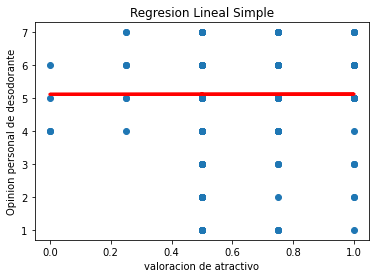

In [933]:
#Separamos los datos de "train" en entrenamiento y prueba
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=15)

#definimos el algoritmo a utilizar
lr = linear_model.LinearRegression()

#Entreno de modelo
lr.fit(X_train, y_train)

#Realizar una prediccion
Y_pred = lr.predict(X_test)

#Graficamos los datos junto con el modelo
plt.scatter(X_test,y_test)
plt.plot(X_test,Y_pred,color='red',linewidth=3)
plt.title('Regresion Lineal Simple')
plt.xlabel('valoracion de atractivo')
plt.ylabel('Opinion personal de desodorante')
plt.show()

In [934]:
print("Mean squeared error: ", mean_squared_error(X_train, y_train))
print("R2 Score: ", lr.score(X_train, y_train))

Mean squeared error:  22.7905625
R2 Score:  5.844466615112509e-07


## Implementacion de la Regresion lineal Multiple

In [935]:
#Regresion Normalizada 
#y_multiple=dataset_norm['q1_1.personal.opinion.of.this.Deodorant'].values
y_multiple=dataset['q1_1.personal.opinion.of.this.Deodorant'].values
y_multiple

array([4, 5, 6, ..., 4, 5, 7], dtype=int64)

Eliminamos las columnas que no nos sirven

In [936]:
def cleanData (dataDrop):
    to_drop=['q1_1.personal.opinion.of.this.Deodorant','Respondent.ID','Product.ID','Product']
    dataDrop.drop(to_drop, inplace=True, axis=1)
    return dataDrop.values

In [937]:
#data = cleanData(dataset_norm)
data = cleanData(dataset)
data

array([[1.        , 1.        , 4.        , ..., 0.        , 3.        ,
        1.44301994],
       [0.        , 1.        , 4.        , ..., 0.        , 4.        ,
        1.44729345],
       [0.        , 1.        , 3.        , ..., 0.        , 2.        ,
        1.44586895],
       ...,
       [1.        , 2.        , 3.        , ..., 0.        , 5.        ,
        2.16310541],
       [0.        , 2.        , 4.        , ..., 0.        , 4.        ,
        2.16132479],
       [0.        , 3.        , 3.        , ..., 0.        , 1.        ,
        2.16310541]])

Creamos la regresion multiple

In [938]:
def regresion_multiple(X_multiple,y_multiple):
    #Separamos los datos de "train" en entrenamiento y prueba
    X_train,X_test,y_train,y_test = train_test_split(X_multiple,y_multiple, test_size=0.2)

    #definimos el algoritmo a utilizar
    lr_multiple = linear_model.LinearRegression()

    #Entreno de modelo
    lr_multiple.fit(X_train,y_train)

    #Realizar una prediccion
    Y_pred_multiple = lr_multiple.predict(X_test)

    print('Datos del modelo de regresion multiple')
    print('--------------------------------------')
    print('Valor de las pendientes o coeficiente "a":')
    print(lr_multiple.coef_)
    print()
    print('Valor de las interseccion de  "b":')
    print(lr_multiple.intercept_)
    print()
    print('Precision del algoritmo:')
    print(lr_multiple.score(X_train,y_train))

regreion multiple con todos los atributos

In [939]:
regresion_multiple(data[:,0:],y_multiple)

Datos del modelo de regresion multiple
--------------------------------------
Valor de las pendientes o coeficiente "a":
[-2.81930852e+00 -1.40635411e-02  4.23347532e-02  1.34228376e-02
  5.58410531e-03 -9.51620471e-03 -1.56164670e-02 -1.50589068e-03
  2.19165201e-03 -1.82939906e-02 -2.08186904e-02 -3.98316564e-03
 -3.12169922e-03 -3.50756468e-02  3.70843053e-03 -7.23263639e-03
  6.91864783e-03 -3.25280896e-02 -1.43592151e-02  1.18599490e-02
 -6.12631974e-03 -2.02813350e-02 -8.52577093e-03 -3.50144881e-02
  3.52498689e-03  6.07959519e-03 -3.28293165e-02 -1.25371235e-02
 -5.41308869e-02  1.00412286e-01 -2.18297487e-02 -5.41007294e-02
  8.31025679e-03  7.86716088e-02  2.73600652e-01  5.06077064e-03
  1.57065524e-03 -2.47476298e-02 -1.24814260e-02 -1.32078610e-02
 -4.30606744e-03  1.52060614e-02  3.90312782e-17 -6.69591059e-03
 -2.02644284e-02 -9.73713362e-03 -2.21993202e-02  8.88070482e-03
 -6.71031228e-02 -3.74367151e-02  6.52857473e-03  9.90148824e-03]

Valor de las interseccion de  "b

regresion multiple sin el atributo Instant.Liking

In [940]:
regresion_multiple(data[:,1:],y_multiple)

Datos del modelo de regresion multiple
--------------------------------------
Valor de las pendientes o coeficiente "a":
[ 6.08434397e-03 -2.78302325e-04  1.61865093e-02 -1.91036615e-02
  1.34149875e-02 -1.77988834e-02 -8.44523347e-03  6.76940794e-03
 -1.52673481e-02 -4.05757935e-02  1.32561221e-03 -1.02992351e-02
 -1.66750132e-02 -2.04501062e-02 -4.65098896e-02 -7.55434350e-03
 -2.53149941e-02 -5.53462738e-02 -2.06848994e-02 -8.73668594e-03
 -3.09177451e-02 -1.52260824e-02 -4.82687830e-02 -5.08645063e-03
  1.60151421e-02 -7.20002456e-03 -1.49141861e-02 -4.69988331e-02
  3.13056808e-02  3.00042165e-02  1.43095439e-01 -1.07204944e-01
  1.27465003e-02 -8.57051468e-01 -1.40218671e-02 -6.15157503e-02
 -4.06259971e-02 -3.15910647e-02 -9.63247617e-03  6.92656392e-03
  4.57926951e-02 -9.71445147e-17 -1.79546046e-02  1.86633483e-02
 -4.23044810e-04 -4.29362461e-02  1.19984894e-03 -1.01901744e-01
 -1.33282986e-01 -1.14112616e-02  2.61629189e-02]

Valor de las interseccion de  "b":
6.72753764101

Podemos observar que unicamente quitando un atributo la precison del modelo es horrible, esto nos permite ver que tan necesario es el el atribtuo Instant.Liking

## Aplicando PCA 

In [948]:
pca = PCA()
# prepare transform on dataset
pca.fit(data)
# apply transform to dataset
transformed = pca.transform(data)
# Defenimos el pipeline
steps = [('pca', PCA(n_components=1)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X_train,y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# Calculamos el Accuracy y el rendimiento
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.317 (0.006)


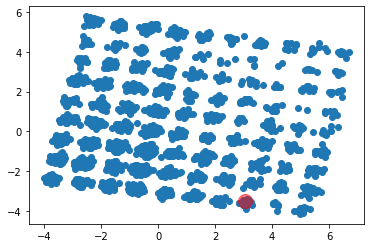

In [942]:
# Entrenamiento modelo PCA con escalado de los datos
#Vuelvo añadir la columna 'q1_1.personal.opinion.of.this.Deodorant'
dataset['q1_1.personal.opinion.of.this.Deodorant']=y_multiple
pca = PCA(n_components=2)
pca.fit(dataset.values)
pcaX=pca.transform(dataset.values)
plt.scatter(pcaX[:, 0], pcaX[:, 1])
plt.scatter([pcaX[10][0]], [pcaX[10][1]],s=[200], c=["r"], alpha=0.5)

original shape:    (53, 2500)
transformed shape: (53, 1)


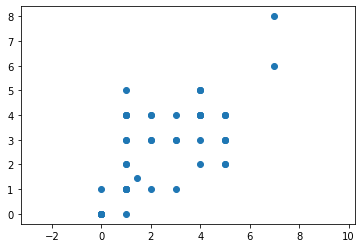

In [962]:
rng = np.random.RandomState(1)
X = dataset.values.T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

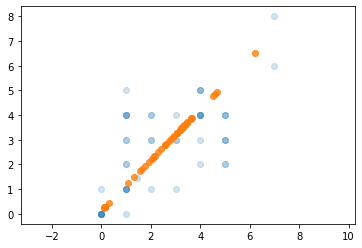

In [963]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

## Preguntas
### Quin són els atributs més importants per fer una bona predicció?
En nuestro caso el atributo mas importante es el Instant.Liking ya que hemos comprobado que, de entre los múltiples elementos que forman nuestro dataset, este dispone de una correlación mas pronunciada con estos.

### Amb quin atribut s'assoleix un MSE menor?
Si bien  el MSE, menor se puede obtener de varios atributos , que podríamos establecer como relación, de la regresión que queramos analizar, y siendo el MSE '0', solo en aquel caso donde los valores de salida, estén contemplados en los valores de entrada, es decir que sean los mismos, tanto los de entrada como salida, en el apartado de regresión lineal simple, hemos planteado dos ejemplos que nos parecieron prácticos para realizar el calculo del MSE, nos dimos cuenta si bien para los atributos  de entrada seleccionados, siendo uno 'q9.how.likely.would.you.be.to.purchase.this.Deodorant' nos generaba un MSE menor,sin embargo,la predicción era muy baja.

### Quina correlació hi ha entre els atributs de la vostra base de dades?
Prácticamente la correlación existente es muy baja, a excepción de  una correlación negativa entre Instant.Liking y q1_1.personal.opinion.of.this.Deodorant..

### Com influeix la normalització en la regressió?
Al intentar normalizar los datos, en nuestro caso lo que sucede es que se pierde la relación entre los atributos sobre los cuales queremos realizar la regresión, ya que por una parte uno de los valores de entrada son de tipo binarios, mientras que los de salida va de un intervalo del 1 al 7, con lo cual en la regresión obtenida, se refleja una relación errónea entre los valores, ya que al normalizar,todos los valores van en intervalos del 1 al 0, con esto no consideremos que la normalización no sea necesaria,  sino mas bien creemos que por la naturaleza y relación de los datos de nuestro dataset, en este caso influye negativamente.

### Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?
Curiosamente no afecta ya que nuestro atributo con mayor peso es el Instant.Liking y cambiar o eliminar otros atributos no tienen el suficiente impacto para variar la regresión lineal, ya que estos no son determinantes, de hecho el resultado de tener en cuenta mas atributos además del Instant.Liking hace que la predicción varié poco

### Si s'aplica un PCA, a quants components es redueix l'espai? Per què?
Como vemos al aplicar el PCA, el espacio se reduce a 1 componente, esto es debido a que la información a lo largo del eje o ejes principales menos importantes se elimina, dejando solo el componente  de los datos con la varianza más alta.

